In [2]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pandas_ta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, RobustScaler
import yfinance as yf

In [3]:
name = 'AAPL'
train_end_date = '2020-01-01'

In [4]:
_ohlc_df = yf.download(name, start='2012-01-01', end=train_end_date)
spy_ohlc_df = yf.download('SPY', start='2012-01-01', end=train_end_date)
msft_ohlc_df = yf.download('MSFT', start='2012-01-01', end=train_end_date)
aapl_ohlc_df = yf.download('AAPL', start='2012-01-01', end=train_end_date)
nvda_ohlc_df = yf.download('NVDA', start='2012-01-01', end=train_end_date)
tsm_ohlc_df = yf.download('TSM', start='2012-01-01', end=train_end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
def get_all_indicators(datafr):
    datafr['1d_close_pct'] = datafr['Close'].pct_change(1)
    datafr['3d_close_pct'] = datafr['Close'].pct_change(3)
    datafr['5d_close_pct'] = datafr['Close'].pct_change(5)
    datafr['10d_close_pct'] = datafr['Close'].pct_change(10)

    datafr['10d_volatility'] = datafr['Close'].rolling(window=10).std()
    tr_df = pd.DataFrame()
    tr_df['High-Low'] = datafr['High'] - datafr['Low']
    tr_df['High-ClosePrev'] = abs(datafr['High'] - datafr['Close'].shift(1))
    tr_df['Low-ClosePrev'] = abs(datafr['Low'] - datafr['Close'].shift(1))
    datafr['TR'] = tr_df[['High-Low', 'High-ClosePrev', 'Low-ClosePrev']].max(axis=1)
    datafr['ATR10'] = datafr['TR'].rolling(window=10).mean()
    datafr['WATR'] = datafr['TR'].rolling(window=14).apply(lambda x: np.average(x, weights=np.arange(1, 14 + 1))) # Weighted Average True Range (WATR)

    log_returns = np.log(datafr['Close']/datafr['Close'].shift(1))
    datafr['VOL'] = log_returns.fillna(0).rolling(window=10).std()*np.sqrt(10) #assuming 252 trading days a year #now we just care about 10
    datafr['VS'] = np.log(datafr['High']) - np.log(datafr['Low'])
    datafr['VP'] = 0.361 * (np.log(datafr['High']/datafr['Low']))**2
    datafr['VGK'] = 0.5 * (np.log(datafr['High'])-np.log(datafr['Low']))**2 - (2*np.log(2)-1)*(np.log(datafr['Close'])-np.log(datafr['Open']))**2
    datafr['VRS'] = (np.log(datafr['High'])-np.log(datafr['Open']))*(np.log(datafr['High'])-np.log(datafr['Close'])) - (np.log(datafr['Low'])-np.log(datafr['Open']))*(np.log(datafr['Low'])-np.log(datafr['Close']))

    datafr['SMA20'] = datafr.Close.rolling(20).mean()
    datafr['EMA20'] = datafr.Close.ewm(span=20).mean()
    datafr['SMA100'] = datafr.Close.rolling(100).mean()
    datafr['EMA100'] = datafr.Close.ewm(span=100).mean()

    datafr['Open_SMA50_diff'] = datafr['Open'].sub(datafr['SMA20'])
    datafr['Open_EMA20_diff'] = datafr['Open'].sub(datafr['EMA20'])
    datafr['Open_SMA100_diff'] = datafr['Open'].sub(datafr['SMA100'])
    datafr['Open_EMA100_diff'] = datafr['Open'].sub(datafr['EMA100'])

    #pandas ta library
    datafr['RSI_14'] = pandas_ta.rsi(datafr['Close'],length=14)
    datafr['RSI_100'] = pandas_ta.rsi(datafr['Close'],length=100)

    vor_df = pandas_ta.vortex(datafr['High'],datafr['Low'],datafr['Close'],14)
    datafr['VTXP_14'] = vor_df['VTXP_14']
    datafr['VTXM_14'] = vor_df['VTXM_14']
    stoch_df = pandas_ta.stoch(datafr['High'],datafr['Low'],datafr['Close'],k=14,d=26)
    datafr['STOCHk_14_26_3'] = stoch_df['STOCHk_14_26_3']
    datafr['STOCHd_14_26_3'] = stoch_df['STOCHd_14_26_3']
    adx_df = pandas_ta.adx(datafr['High'],datafr['Low'],datafr['Close'],length=14)#average directional index
    datafr['ADX_14'] = adx_df['ADX_14']
    datafr['DMP_14'] = adx_df['DMP_14']
    datafr['DMN_14'] = adx_df['DMN_14']
    amat_df = pandas_ta.amat(datafr['Close']) #Archer Moving Averages Trends
    datafr['AMATe_LR_8_21_2'] = amat_df['AMATe_LR_8_21_2']
    datafr['AMATe_SR_8_21_2'] = amat_df['AMATe_SR_8_21_2']
    aroon_df = pandas_ta.aroon(datafr['High'],datafr['Low']) #Aroon & Aroon Oscillator
    datafr['AROOND_14'] = aroon_df['AROOND_14']
    datafr['AROONU_14'] = aroon_df['AROONU_14']
    datafr['AROONOSC_14'] = aroon_df['AROONOSC_14']
    ao_df = pandas_ta.ao(datafr['High'],datafr['Low'])#Awesome Oscillator
    datafr['AO_5_34'] = ao_df
    uo_df = pandas_ta.uo(datafr['High'],datafr['Low'],datafr['Close'])#Ultimate Oscillator
    datafr['UO_7_14_28'] = uo_df
    cg_df = pandas_ta.cg(datafr['Close'])#Center of Gravity
    datafr['CG_10'] = cg_df
    coppock_df = pandas_ta.coppock(datafr['Close'])#Coppock
    datafr['COPC_11_14_10'] = coppock_df
    inertia_df = pandas_ta.inertia(datafr['Close'],datafr['High'],datafr['Low'])#inertia
    datafr['INERTIA_20_14'] = inertia_df
    stc_df = pandas_ta.stc(datafr['Close']) #schaff trend cycle
    datafr['STC_10_12_26_0.5'] = stc_df['STC_10_12_26_0.5']
    datafr['STCmacd_10_12_26_0.5'] = stc_df['STCmacd_10_12_26_0.5']
    datafr['STCstoch_10_12_26_0.5'] = stc_df['STCstoch_10_12_26_0.5']
    tsi_df = pandas_ta.tsi(datafr['Close']) # true strength index
    datafr['TSI_13_25_13'] = tsi_df['TSI_13_25_13']
    qstick_df = pandas_ta.qstick(datafr['Open'],datafr['Close']) #q stick indicator
    datafr['QS_10'] = qstick_df
    vhf_df = pandas_ta.vhf(datafr['Close'])#vertical horizontal filter
    datafr['VHF_28'] = vhf_df
    dpo_df = pandas_ta.dpo(datafr['Close']) #detrend price oscillator
    datafr['DPO_20'] = dpo_df
    pdist_df = pandas_ta.pdist(datafr['Open'],datafr['High'],datafr['Low'],datafr['Close'])
    datafr['PDIST'] = pdist_df
    rvi_df = pandas_ta.rvi(datafr['Close'],datafr['High'],datafr['Low']) #relative volatility index
    datafr['RVI_14'] = rvi_df
    willr_df = pandas_ta.willr(datafr['High'],datafr['Low'],datafr['Close']) # William's Percent R (WILLR)
    datafr['WILLR_14'] = willr_df
    ebsw_df = pandas_ta.ebsw(datafr['Close']) #Even Better SineWave (EBSW)
    datafr['EBSW_40_10'] = ebsw_df
    kurt_df = pandas_ta.kurtosis(datafr['Close']) #kurtosis
    datafr['KURT_30'] = kurt_df
    zscore_df = pandas_ta.zscore(datafr['Close'])
    datafr['ZS_30'] = zscore_df
    chop_df = pandas_ta.chop(datafr['High'],datafr['Low'],datafr['Close']) #choppiness index
    datafr['CHOP_14_1_100'] = chop_df

    print(datafr.shape)
    datafr = datafr.dropna()
    print(datafr.shape)

    return datafr

In [6]:
_ohlc_df = get_all_indicators(_ohlc_df)
spy_ohlc_df = get_all_indicators(spy_ohlc_df)
aapl_ohlc_df = get_all_indicators(aapl_ohlc_df)
msft_ohlc_df = get_all_indicators(msft_ohlc_df)
nvda_ohlc_df = get_all_indicators(nvda_ohlc_df)


(2012, 60)
(1901, 60)
(2012, 60)
(1901, 60)
(2012, 60)
(1901, 60)
(2012, 60)
(1901, 60)
(2012, 60)
(1901, 60)


In [7]:
def prepare_dataframe(df,cols_to_use,close_col_idx=3):
    updated_df = df.copy()

    updated_df = updated_df[cols_to_use] 
    upd_scaler = StandardScaler()
    upd_scaler = upd_scaler.fit(updated_df)
    updated_df_scaled = upd_scaler.transform(updated_df)

    X = []
    Y = []
    n_future = 1   # Number of days we want to look into the future based on the past days.
    global n_past
    n_past = 14  # Number of past days we want to use to predict the future.
    for i in range(n_past, len(updated_df_scaled) - n_future + 1,n_future):
        X.append(updated_df_scaled[i - n_past:i, 0:updated_df_scaled.shape[1]])
        Y.append(updated_df_scaled[i + n_future - 1:i + n_future, close_col_idx]) #index 0 is Open, 3 is Close
        # Y.append(updated_df_scaled[i:i + n_future, 0]) #index 0 is Open

    return np.array(X), np.array(Y), upd_scaler

In [8]:
#prepare training data
df = _ohlc_df.copy()
df = df.reset_index().rename(columns={'index': 'Date'})
date_array = df['Date'].to_numpy()
date_series = df['Date']
cols = list(df)[1:]
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Clos
df_for_training = df[cols].astype(float)
df_for_training1 = spy_ohlc_df[cols].astype(float)
df_for_training2 = msft_ohlc_df[cols].astype(float)
df_for_training3 = aapl_ohlc_df[cols].astype(float)
df_for_training4 = nvda_ohlc_df[cols].astype(float)


columns_to_use = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1d_close_pct',
       '3d_close_pct', '5d_close_pct', '10d_close_pct', '10d_volatility', 'TR',
       'ATR10', 'WATR', 'VOL', 'VS', 'VP', 'VGK', 'VRS', 'SMA20', 'EMA20', 
       'SMA100', 'EMA100','Open_EMA20_diff', 'Open_SMA100_diff',
       'Open_EMA100_diff', 'RSI_14', 'RSI_100', 'VTXP_14', 'VTXM_14',
       'STOCHk_14_26_3', 'STOCHd_14_26_3', 'ADX_14', 'DMP_14', 'DMN_14',
       'AMATe_LR_8_21_2', 'AMATe_SR_8_21_2', 'AROOND_14', 'AROONU_14',
       'AROONOSC_14', 'AO_5_34',
       'UO_7_14_28', 'CG_10', 'COPC_11_14_10', 'INERTIA_20_14',
       'STC_10_12_26_0.5', 'STCmacd_10_12_26_0.5', 'STCstoch_10_12_26_0.5',
       'TSI_13_25_13', 'QS_10', 'VHF_28', 'DPO_20', 'PDIST', 'RVI_14',
       'WILLR_14', 'EBSW_40_10', 'KURT_30', 'ZS_30', 'CHOP_14_1_100']

trainX, trainY, train_scaler = prepare_dataframe(df_for_training,columns_to_use)
trainX1, trainY1, train_scaler = prepare_dataframe(df_for_training1,columns_to_use)
trainX2, trainY2, train_scaler = prepare_dataframe(df_for_training2,columns_to_use)
trainX3, trainY3, train_scaler = prepare_dataframe(df_for_training3,columns_to_use)
trainX4, trainY4, train_scaler = prepare_dataframe(df_for_training4,columns_to_use)

columns_to_use_min_min = ['Close']
trainX_min_min, trainY_min_min, train_scaler = prepare_dataframe(df_for_training,columns_to_use_min_min,0)
trainX1_min_min, trainY1_min_min, train_scaler = prepare_dataframe(df_for_training1,columns_to_use_min_min,0)
trainX2_min_min, trainY2_min_min, train_scaler = prepare_dataframe(df_for_training2,columns_to_use_min_min,0)
trainX3_min_min, trainY3_min_min, train_scaler = prepare_dataframe(df_for_training3,columns_to_use_min_min,0)
trainX4_min_min, trainY4_min_min, train_scaler = prepare_dataframe(df_for_training4,columns_to_use_min_min,0)

columns_to_use_min = ['Open', 'High', 'Low', 'Close', 'Volume']
trainX_min, trainY_min, train_scaler = prepare_dataframe(df_for_training,columns_to_use_min)
trainX1_min, trainY1_min, train_scaler = prepare_dataframe(df_for_training1,columns_to_use_min)
trainX2_min, trainY2_min, train_scaler = prepare_dataframe(df_for_training2,columns_to_use_min)
trainX3_min, trainY3_min, train_scaler = prepare_dataframe(df_for_training3,columns_to_use_min)
trainX4_min, trainY4_min, train_scaler = prepare_dataframe(df_for_training4,columns_to_use_min)

columns_to_use_2 = ['Close', 'ATR10']
trainX_2, trainY_2, train_scaler = prepare_dataframe(df_for_training,columns_to_use_2,0)
trainX1_2, trainY1_2, train_scaler = prepare_dataframe(df_for_training1,columns_to_use_2,0)
trainX2_2, trainY2_2, train_scaler = prepare_dataframe(df_for_training2,columns_to_use_2,0)
trainX3_2, trainY3_2, train_scaler = prepare_dataframe(df_for_training3,columns_to_use_2,0)
trainX4_2, trainY4_2, train_scaler = prepare_dataframe(df_for_training4,columns_to_use_2,0)

columns_to_use_7 = ['Close', '1d_close_pct', 'ATR10', 'VOL', 'EMA20', 'PDIST', 'ADX_14']
trainX_7, trainY_7, train_scaler = prepare_dataframe(df_for_training,columns_to_use_7,0)
trainX1_7, trainY1_7, train_scaler = prepare_dataframe(df_for_training1,columns_to_use_7,0)
trainX2_7, trainY2_7, train_scaler = prepare_dataframe(df_for_training2,columns_to_use_7,0)
trainX3_7, trainY3_7, train_scaler = prepare_dataframe(df_for_training3,columns_to_use_7,0)
trainX4_7, trainY4_7, train_scaler = prepare_dataframe(df_for_training4,columns_to_use_7,0)


['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1d_close_pct', '3d_close_pct', '5d_close_pct', '10d_close_pct', '10d_volatility', 'TR', 'ATR10', 'WATR', 'VOL', 'VS', 'VP', 'VGK', 'VRS', 'SMA20', 'EMA20', 'SMA100', 'EMA100', 'Open_SMA50_diff', 'Open_EMA20_diff', 'Open_SMA100_diff', 'Open_EMA100_diff', 'RSI_14', 'RSI_100', 'VTXP_14', 'VTXM_14', 'STOCHk_14_26_3', 'STOCHd_14_26_3', 'ADX_14', 'DMP_14', 'DMN_14', 'AMATe_LR_8_21_2', 'AMATe_SR_8_21_2', 'AROOND_14', 'AROONU_14', 'AROONOSC_14', 'AO_5_34', 'UO_7_14_28', 'CG_10', 'COPC_11_14_10', 'INERTIA_20_14', 'STC_10_12_26_0.5', 'STCmacd_10_12_26_0.5', 'STCstoch_10_12_26_0.5', 'TSI_13_25_13', 'QS_10', 'VHF_28', 'DPO_20', 'PDIST', 'RVI_14', 'WILLR_14', 'EBSW_40_10', 'KURT_30', 'ZS_30', 'CHOP_14_1_100']


In [9]:
def build_lstm_model(input_shape):

    inputs = tf.keras.layers.Input(shape=input_shape)
    lstm_output1 = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
    dropout_output1 = tf.keras.layers.Dropout(0.3)(lstm_output1)  # Adding dropout with a rate of 0.2
    lstm_output2 = tf.keras.layers.LSTM(128, return_sequences=True)(dropout_output1)
    dropout_output2 = tf.keras.layers.Dropout(0.3)(lstm_output2)  
    lstm_output3 = tf.keras.layers.LSTM(128, return_sequences=False)(dropout_output2)
    dropout_output3 = tf.keras.layers.Dropout(0.3)(lstm_output3)  

    flat_mean_output = tf.keras.layers.Dense(5, activation='relu')(dropout_output3) 
    output_mean = tf.keras.layers.Dense(1)(flat_mean_output)  # Output for mean prediction

    model = tf.keras.models.Model(inputs=inputs, outputs=output_mean)

    return model

In [10]:
# #transfer learned w/ everything
deep_model = build_lstm_model(input_shape=(n_past, len(columns_to_use)))
deep_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X = np.concatenate((trainX1,trainX2,trainX3,trainX4,trainX),axis=0)
big_train_Y = np.concatenate((trainY1,trainY2,trainY3,trainY4,trainY),axis=0)

history = deep_model.fit(big_train_X, big_train_Y, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

In [11]:
deep_model_min = build_lstm_model(input_shape=(n_past, len(columns_to_use_min)))
deep_model_min.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X_min = np.concatenate((trainX1_min,trainX2_min,trainX3_min,trainX4_min,trainX_min),axis=0)
big_train_Y_min = np.concatenate((trainY1_min,trainY2_min,trainY3_min,trainY4_min,trainY_min),axis=0)
history_min = deep_model_min.fit(big_train_X_min, big_train_Y_min, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

In [12]:
deep_model_min_min = build_lstm_model(input_shape=(n_past, len(columns_to_use_min_min)))
deep_model_min_min.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X_min_min = np.concatenate((trainX1_min_min,trainX2_min_min,trainX3_min_min,trainX4_min_min,trainX_min_min),axis=0)
big_train_Y_min_min = np.concatenate((trainY1_min_min,trainY2_min_min,trainY3_min_min,trainY4_min_min,trainY_min_min),axis=0)
history_min_min = deep_model_min_min.fit(big_train_X_min_min, big_train_Y_min_min, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

In [13]:
deep_model_2 = build_lstm_model(input_shape=(n_past, len(columns_to_use_2)))
deep_model_2.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X_2 = np.concatenate((trainX1_2,trainX2_2,trainX3_2,trainX4_2,trainX_2),axis=0)
big_train_Y_2 = np.concatenate((trainY1_2,trainY2_2,trainY3_2,trainY4_2,trainY_2),axis=0)
history_2 = deep_model_2.fit(big_train_X_2, big_train_Y_2, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

In [14]:
deep_model_7 = build_lstm_model(input_shape=(n_past, len(columns_to_use_7)))
deep_model_7.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse')
big_train_X_7 = np.concatenate((trainX1_7,trainX2_7,trainX3_7,trainX4_7,trainX_7),axis=0)
big_train_Y_7 = np.concatenate((trainY1_7,trainY2_7,trainY3_7,trainY4_7,trainY_7),axis=0)
history_7 = deep_model_7.fit(big_train_X_7, big_train_Y_7, epochs=15, batch_size=16, validation_split=0.3, verbose=0)

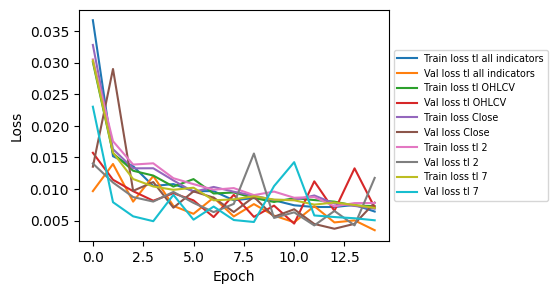

In [15]:
plt.figure(figsize=(4,3))
plt.plot(history.history['loss'], label='Train loss tl all indicators')
plt.plot(history.history['val_loss'], label='Val loss tl all indicators')
plt.plot(history_min.history['loss'], label='Train loss tl OHLCV')
plt.plot(history_min.history['val_loss'], label='Val loss tl OHLCV')
plt.plot(history_min_min.history['loss'], label='Train loss Close')
plt.plot(history_min_min.history['val_loss'], label='Val loss Close')
plt.plot(history_2.history['loss'], label='Train loss tl 2')
plt.plot(history_2.history['val_loss'], label='Val loss tl 2')
plt.plot(history_7.history['loss'], label='Train loss tl 7')
plt.plot(history_7.history['val_loss'], label='Val loss tl 7')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='x-small')
plt.show()

In [16]:
# train_end_date = '2017-12-31'
print(train_end_date)
forecast_df = yf.download(name, start=train_end_date, end='2023-07-01')
forecast_df = forecast_df.reset_index().rename(columns={'index': 'Date'})

2020-01-01
[*********************100%***********************]  1 of 1 completed


In [17]:
forecast_df = get_all_indicators(forecast_df)

(880, 61)
(769, 61)


In [18]:
forecast_date_array = forecast_df['Date'].to_numpy()[n_past:]
truth_opens = forecast_df['Open'].values[n_past:]
truth_closes = forecast_df['Close'].values[n_past:]
truth_sma = forecast_df['SMA20'].values[n_past:]
truth_vs = forecast_df['TR'].values[n_past:]

testX, testY, scaler = prepare_dataframe(forecast_df,columns_to_use)
testX_min, testY_min, scaler_min = prepare_dataframe(forecast_df,columns_to_use_min)
testX_min_min, testY_min_min, scaler_min_min = prepare_dataframe(forecast_df,columns_to_use_min_min,0)
testX_2, testY_2, scaler_2 = prepare_dataframe(forecast_df,columns_to_use_2,0)
testX_7, testY_7, scaler_7 = prepare_dataframe(forecast_df,columns_to_use_7,0)

#predict the open max columns -transfer
forecast = deep_model.predict(testX)
forecast_copies = np.repeat(forecast,len(columns_to_use),axis=-1)
y_pred = scaler.inverse_transform(forecast_copies)[:,3]

#predict the open min columns -transfer
forecast_min = deep_model_min.predict(testX_min)
forecast_copies_min = np.repeat(forecast_min,len(columns_to_use_min),axis=-1)
y_pred_min = scaler_min.inverse_transform(forecast_copies_min)[:,3]

#predict the close min min
forecast_min_min = deep_model_min_min.predict(testX_min_min)
y_pred_min_min = scaler_min_min.inverse_transform(forecast_copies_min)[:,0]

#predict the close min min
forecast_2 = deep_model_2.predict(testX_2)
forecast_copies_2 = np.repeat(forecast_2,len(columns_to_use_2),axis=-1)
y_pred_2 = scaler_2.inverse_transform(forecast_copies_2)[:,0]

#predict the close min min
forecast_7 = deep_model_7.predict(testX_7)
forecast_copies_7 = np.repeat(forecast_7,len(columns_to_use_7),axis=-1)
y_pred_7 = scaler_7.inverse_transform(forecast_copies_7)[:,0]

print(y_pred.shape)
print(y_pred_min.shape)
print(y_pred_min_min.shape)
print(y_pred_2.shape)
print(y_pred_7.shape)




prediction_df = pd.DataFrame({'Date':forecast_date_array,'Close':truth_closes, 'SMA20':truth_sma,
                              'Close_pred':y_pred, 'Close_pred_min':y_pred_min,
                              'Close_pred_min_min':y_pred_min_min, 
                              'Close_pred_2':y_pred_2, 'Close_pred_7':y_pred_7})

24/24 [==============================] - 1s 8ms/step
(755,)
(755,)
(755,)
(755,)
(755,)


In [41]:
prediction_df.tail()

,Date,Close,SMA20,Close_pred,Close_pred_min,Close_pred_min_min,Close_pred_2,Close_pred_7
750,2023-06-08,180.570007,175.607502,177.245758,181.271530,181.271530,174.880386,176.734909
751,2023-06-09,180.960007,175.968002,178.063446,181.609161,181.609161,175.536331,177.837860
752,2023-06-12,183.789993,176.529002,178.635513,182.676819,182.676819,176.329254,178.519547
753,2023-06-13,183.309998,177.091001,179.656952,183.896637,183.896637,177.862411,179.901917
754,2023-06-14,183.949997,177.685001,179.887161,184.738449,184.738449,178.694229,180.337341


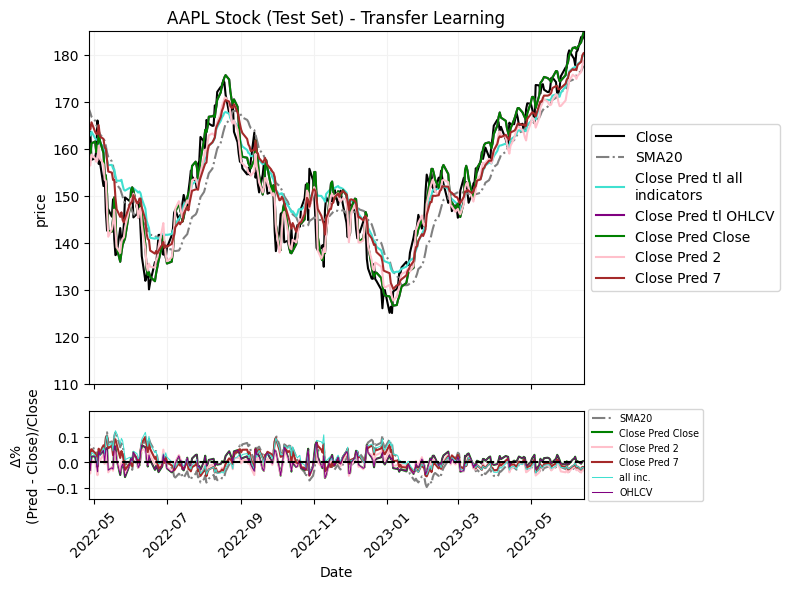

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax[0].plot(prediction_df.Date,prediction_df.Close,label='Close',color='black')
ax[0].plot(prediction_df.Date,prediction_df.SMA20,ls='-.',label='SMA20',color='grey')
# ax[0].plot(prediction_df.Date,prediction_df.Close_pred,label=f'Close Pred all\nindicators',color='red')
# ax[0].plot(prediction_df.Date,prediction_df.Close_pred_min,label=f'Close Pred OHLCV ',color='orange')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred,label=f'Close Pred tl all\nindicators',color='turquoise')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_min,label=f'Close Pred tl OHLCV',color='purple')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_min_min,label=f'Close Pred Close',color='green')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_2,label=f'Close Pred 2',color='pink')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_7,label=f'Close Pred 7',color='brown')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel('price')
ax[0].set_title(name +' Stock (Test Set) - Transfer Learning')
ax[0].grid(color="0.95")

ax[1].plot(prediction_df.Date, (prediction_df.SMA20 - prediction_df.Close)/prediction_df.Close, color='grey',label='SMA20',ls='-.')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_min_min- prediction_df.Close)/prediction_df.Close,label=f'Close Pred Close',color='green')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_2- prediction_df.Close)/prediction_df.Close,label=f'Close Pred 2',color='pink')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_7- prediction_df.Close)/prediction_df.Close,label=f'Close Pred 7',color='brown')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred - prediction_df.Close)/prediction_df.Close, color='turquoise',label='all inc.',lw=0.75)
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_min - prediction_df.Close)/prediction_df.Close, color='purple',label='OHLCV',lw=0.75)
ax[1].axhline(0,ls='--',color='black')
ax[1].set_ylabel('$\Delta$%\n(Pred - Close)/Close')
ax[1].set_xlabel('Date')
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].grid(color="0.95")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='x-small')
ax[1].set_xlim(prediction_df.Date.iloc[470],prediction_df.Date.iloc[-1])
ax[0].set_ylim(110,185)
plt.tight_layout()
plt.show()

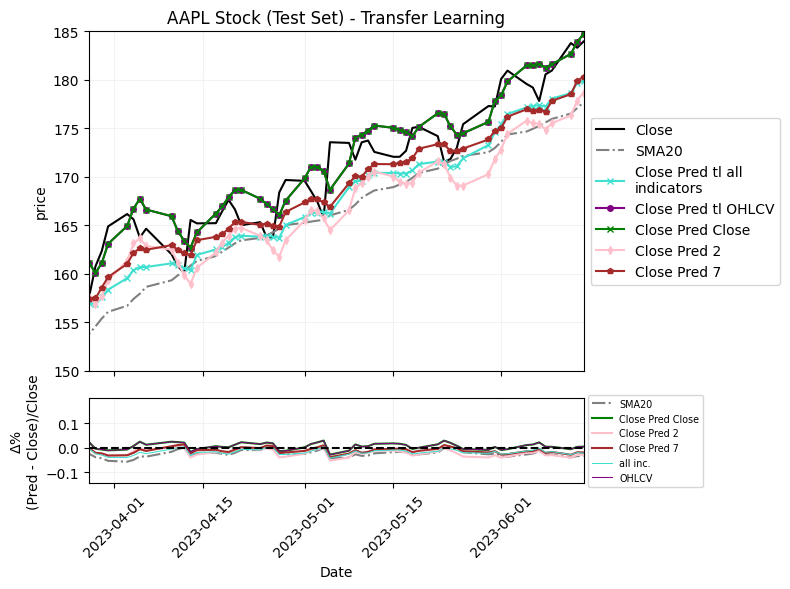

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax[0].plot(prediction_df.Date,prediction_df.Close,label='Close',color='black')
ax[0].plot(prediction_df.Date,prediction_df.SMA20,ls='-.',label='SMA20',color='grey')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred,label=f'Close Pred tl all\nindicators',color='turquoise',marker='x',ms=4)
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_min,label=f'Close Pred tl OHLCV',color='purple',marker='o',ms=4)
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_min_min,label=f'Close Pred Close',color='green',marker='x',ms=4)
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_2,label=f'Close Pred 2',color='pink',marker='d',ms=4)
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_7,label=f'Close Pred 7',color='brown',marker='p',ms=4)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel('price')
ax[0].set_title(name +' Stock (Test Set) - Transfer Learning')
ax[0].grid(color="0.95")

ax[1].plot(prediction_df.Date, (prediction_df.SMA20 - prediction_df.Close)/prediction_df.Close, color='grey',label='SMA20',ls='-.')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_min_min- prediction_df.Close)/prediction_df.Close,label=f'Close Pred Close',color='green')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_2- prediction_df.Close)/prediction_df.Close,label=f'Close Pred 2',color='pink')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_7- prediction_df.Close)/prediction_df.Close,label=f'Close Pred 7',color='brown')
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred - prediction_df.Close)/prediction_df.Close, color='turquoise',label='all inc.',lw=0.75)
ax[1].plot(prediction_df.Date, (prediction_df.Close_pred_min - prediction_df.Close)/prediction_df.Close, color='purple',label='OHLCV',lw=0.75)
ax[1].axhline(0,ls='--',color='black')
ax[1].set_ylabel('$\Delta$%\n(Pred - Close)/Close')
ax[1].set_xlabel('Date')
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].grid(color="0.95")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='x-small')
ax[1].set_xlim(prediction_df.Date.iloc[700],prediction_df.Date.iloc[-1])
ax[0].set_ylim(150,185)
plt.tight_layout()
plt.show()

In [180]:
forecast_df2 = yf.download(name, start='2022-11-30', end='2023-07-01')
forecast_df2 = forecast_df2.reset_index().rename(columns={'index': 'Date'})
forecast_df2 = get_all_indicators(forecast_df2)

[*********************100%***********************]  1 of 1 completed
(146, 61)
(35, 61)


In [181]:
forecast_date_array = forecast_df2['Date'].to_numpy()[n_past:]
truth_opens = forecast_df2['Open'].values[n_past:]
truth_closes = forecast_df2['Close'].values[n_past:]
truth_sma = forecast_df2['SMA20'].values[n_past:]
testX, testY, scaler = prepare_dataframe(forecast_df2,columns_to_use)
testX_min, testY_min, scaler2 = prepare_dataframe(forecast_df2,columns_to_use_min)

#predict the open max columns 
forecast1 = model1.predict(testX)
forecast1_copies = np.repeat(forecast1,len(columns_to_use),axis=-1)
y_pred_model1 = scaler.inverse_transform(forecast1_copies)[:,3]

#predict the open min columns
forecast2 = model2.predict(testX_min)
forecast2_copies = np.repeat(forecast2,len(columns_to_use_min),axis=-1)
y_pred_model2 = scaler2.inverse_transform(forecast2_copies)[:,3]

#predict the open max columns -transfer
forecast = deep_model.predict(testX)
forecast_copies = np.repeat(forecast,len(columns_to_use),axis=-1)
y_pred = scaler.inverse_transform(forecast_copies)[:,3]

#predict the open min columns -transfer
forecast_min = deep_model_min.predict(testX_min)
forecast_copies_min = np.repeat(forecast_min,len(columns_to_use_min),axis=-1)
y_pred_min = scaler2.inverse_transform(forecast_copies_min)[:,3]


prediction_df = pd.DataFrame({'Date':forecast_date_array,'Close':truth_closes, 'SMA20':truth_sma,
                              'Close_pred':y_pred_model1, 'Close_pred_min': y_pred_model2,
                              'Close_pred_tl':y_pred, 'Close_pred_tl_min':y_pred_min})

1/1 [==============================] - 0s 25ms/step


In [182]:
prediction_df.head()

,Date,Close,SMA20,Close_pred,Close_pred_min,Close_pred_tl,Close_pred_tl_min
0,2023-05-16,311.739990,301.231998,311.126678,307.637817,307.348694,308.580780
1,2023-05-17,314.000000,302.509497,310.991730,308.289307,308.167786,309.340088
2,2023-05-18,318.519989,304.129997,311.020355,308.871399,309.080627,310.565033
3,2023-05-19,318.339996,305.758997,311.164215,309.495361,310.071381,314.207062
4,2023-05-22,321.179993,307.729497,311.454865,310.289703,311.015594,317.045258


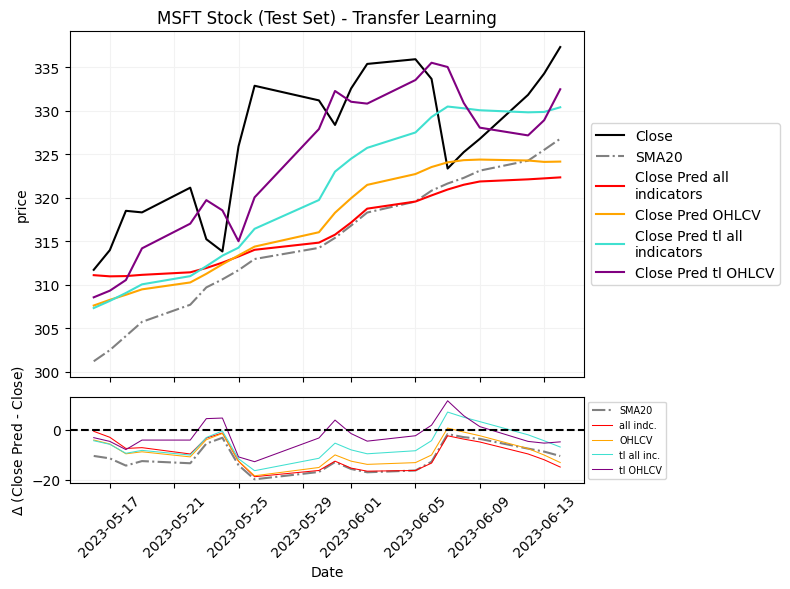

In [183]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax[0].plot(prediction_df.Date,prediction_df.Close,label='Close',color='black')
ax[0].plot(prediction_df.Date,prediction_df.SMA20,ls='-.',label='SMA20',color='grey')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred,label=f'Close Pred all\nindicators',color='red')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_min,label=f'Close Pred OHLCV ',color='orange')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_tl,label=f'Close Pred tl all\nindicators',color='turquoise')
ax[0].plot(prediction_df.Date,prediction_df.Close_pred_tl_min,label=f'Close Pred tl OHLCV',color='purple')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel('price')
ax[0].set_title(name +' Stock (Test Set) - Transfer Learning')
ax[0].grid(color="0.95")

ax[1].plot(prediction_df.Date, prediction_df.SMA20 - prediction_df.Close, color='grey',label='SMA20',ls='-.')
ax[1].plot(prediction_df.Date, prediction_df.Close_pred - prediction_df.Close, color='red',label='all indc.',lw=0.75)
ax[1].plot(prediction_df.Date, prediction_df.Close_pred_min - prediction_df.Close, color='orange',label='OHLCV',lw=0.75)
ax[1].plot(prediction_df.Date, prediction_df.Close_pred_tl - prediction_df.Close, color='turquoise',label='tl all inc.',lw=0.75)
ax[1].plot(prediction_df.Date, prediction_df.Close_pred_tl_min - prediction_df.Close, color='purple',label='tl OHLCV',lw=0.75)
ax[1].axhline(0,ls='--',color='black')
ax[1].set_ylabel('$\Delta$ (Close Pred - Close)')
ax[1].set_xlabel('Date')
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].grid(color="0.95")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='x-small')

plt.tight_layout()
plt.show()

In [189]:
forecast_df3 = yf.download(name, start='2023-05-01', end='2023-07-12')
# forecast_df3 = yf.download(name, start='2023-06-09', end='2023-07-01')
forecast_df3 = forecast_df3.reset_index().rename(columns={'index': 'Date'})

[*********************100%***********************]  1 of 1 completed


In [190]:
forecast_date_array = forecast_df3['Date'].values[n_past:]
truth_closes = forecast_df3['Close'].values[n_past:]
testX_min, testY_min, scaler2 = prepare_dataframe(forecast_df3,columns_to_use_min)

#get the truths back
truth_copies = np.repeat(testY_min,len(columns_to_use_min),axis=-1)
unscaled_truth = scaler2.inverse_transform(truth_copies)[:,3]

#predict the open min columns
forecast2 = model2.predict(testX_min)
forecast2_copies = np.repeat(forecast2,len(columns_to_use_min),axis=-1)
y_pred_model2 = scaler2.inverse_transform(forecast2_copies)[:,3]

#predict the open min columns -transfer
forecast_min = deep_model_min.predict(testX_min)
forecast_copies_min = np.repeat(forecast_min,len(columns_to_use_min),axis=-1)
y_pred_min = scaler2.inverse_transform(forecast_copies_min)[:,3]

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


In [191]:
print('Di model ',y_pred_model2)
print('TL model ',y_pred_min)
print('Truth    ',unscaled_truth)
print('Date    ',forecast_date_array)

Di model  [310.70935 311.0739  311.6177  312.3111  313.04962 313.91388 315.09503
 316.6792  318.43692 320.35727 322.5687  325.74857 327.5103  328.29965
 328.73697 328.68433 328.41208 328.29904 328.3584  329.0288  329.8701
 330.66983 331.40668 331.65558 331.71613 331.51926 331.22876 331.18173
 330.9465  330.8914  331.03888 331.29855 331.68698 332.27896 332.93237]
TL model  [311.00143 312.68567 314.5006  315.20135 314.6641  317.17404 324.8504
 332.1513  331.1081  330.28622 333.54956 336.02902 335.6597  330.16785
 324.94275 324.26437 328.21548 333.82462 336.8504  341.9999  343.56982
 341.50668 338.49573 337.84775 336.91168 334.16092 333.08038 334.89108
 335.63007 338.2819  339.417   338.905   339.1731  339.1216  335.55347]
Truth     [318.33999634 321.17999268 315.26000977 313.8500061  325.92001343
 332.89001465 331.20999146 328.39001465 332.57998657 335.3999939
 335.94000244 333.67999268 323.38000488 325.26000977 326.79000854
 331.8500061  334.29000854 337.33999634 348.1000061  342.329986

In [192]:
print(testX_min.shape)
np.set_printoptions(suppress=True)
give_to_the_model = testX_min.reshape(-1,5)
unscaled_give_to_the_model = scaler2.inverse_transform(give_to_the_model)
for day in unscaled_give_to_the_model:
    print(day)

(35, 14, 5)
[     306.97000122      308.6000061       305.1499939       305.55999756
 21294100.        ]
[     307.76000977      309.17999268      303.91000366      305.41000366
 26404400.        ]
[     306.61999512      308.60998535      304.08999634      304.3999939
 22360800.        ]
[     306.23999023      307.76000977      303.3999939       305.41000366
 22519900.        ]
[     305.72000122      311.97000122      304.26998901      310.6499939
 28181200.        ]
[     310.13000488      310.20001221      306.08999634      308.6499939
 21318600.        ]
[     308.              310.04000854      306.30999756      307.
 21340800.        ]
[     308.61999512      313.              307.67001343      312.30999756
 30078000.        ]
[     310.1000061       311.11999512      306.26000977      310.10998535
 31680200.        ]
[     310.54998779      310.6499939       306.6000061       308.97000122
 19758100.        ]
[     309.1000061       309.8999939       307.58999634      309.45999

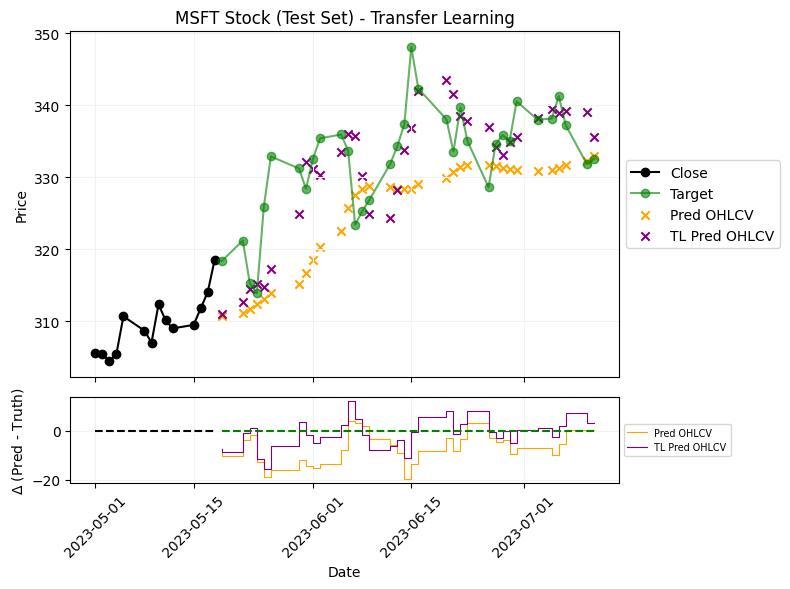

In [195]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax[0].plot(forecast_df3['Date'].values[:n_past],forecast_df3['Close'].values[:n_past],marker='o',ls='-',label='Close',color='black')
ax[0].plot(forecast_df3['Date'].values[n_past:],unscaled_truth,'-o',label='Target',color='green',alpha=0.6)
ax[0].scatter(forecast_df3['Date'].values[n_past:],y_pred_model2,label='Pred OHLCV',color='orange',marker='x')
ax[0].scatter(forecast_df3['Date'].values[n_past:],y_pred_min,label='TL Pred OHLCV',color='purple',marker='x')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set(ylabel='Price',title=name +' Stock (Test Set) - Transfer Learning')
ax[0].grid(color="0.95")

ax[1].step(forecast_df3['Date'].values[n_past:],y_pred_model2-unscaled_truth,label='Pred OHLCV',color='orange',lw=0.8)
ax[1].step(forecast_df3['Date'].values[n_past:],y_pred_min-unscaled_truth,label='TL Pred OHLCV',color='purple',lw=0.8)
ax[1].hlines(0,min(forecast_df3['Date'].values[n_past:]),max(forecast_df3['Date'].values[n_past:]),color='green',ls='--')
ax[1].hlines(0,min(forecast_df3['Date'].values[:n_past]),max(forecast_df3['Date'].values[:n_past]),color='black',ls='--')

ax[1].set(xlabel='Date',ylabel='$\Delta$ (Pred - Truth)')
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].grid(color="0.95")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize='x-small')

plt.tight_layout()
plt.show()

(880, 66)
(769, 66)


In [103]:
forecast_date_array = forecast_df['Date'].to_numpy()[n_past:]
truth_opens = forecast_df['Open'].values[n_past:]
truth_closes = forecast_df['Close'].values[n_past:]

testX, testY, scaler = prepare_dataframe(forecast_df,columns_to_use)

#predict the open (up) sequences and unscale
forecast = deep_model.predict(testX)
unscaled_forecast = np.zeros_like(forecast)
for i in range(forecast.shape[1]):
    day_i = forecast[:,i].reshape(-1,1)
    copy = np.repeat(day_i,len(columns_to_use),axis=-1)
    unscaled_preds = scaler.inverse_transform(copy)[:,0]
    unscaled_forecast[:,i] = unscaled_preds


# forecast_copies = np.repeat(forecast,len(columns_to_use),axis=-1)
# y_pred = scaler.inverse_transform(forecast_copies)[:,0]

# prediction_df = pd.DataFrame({'Date':forecast_date_array,'Open':truth_opens,'Open_pred':y_pred})

8/8 [==============================] - 1s 7ms/step


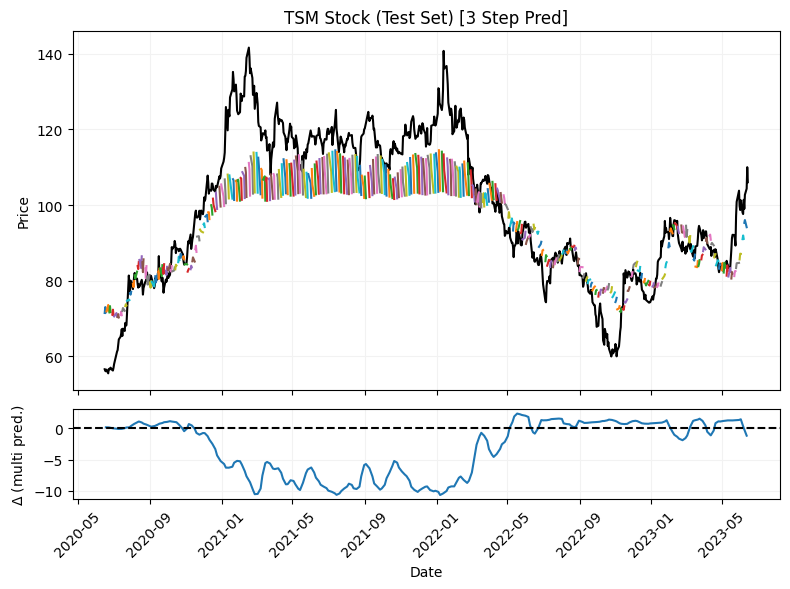

In [104]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4,1]})
step = 3
ax[0].set_title(name +' Stock (Test Set) ['+str(step)+' Step Pred]')
ax[0].set_ylabel('Price')
ax[0].grid(color="0.95")
ax[0].plot(forecast_date_array,truth_opens,label='Open',color='black')
counter = 0
sub_x,sub_y = [],[]
for i in range(len(unscaled_forecast)):
    xs = forecast_date_array[counter:counter+step]
    xs2 = forecast_date_array[counter+step-1]
    ys = unscaled_forecast[i]
    ys2 = ys[-1]-ys[0]
    counter += step
    ax[0].plot(xs,ys)
    #plot the arrows
    sub_x.append(xs2)
    sub_y.append(ys2)

# ax[0].set(xlim=(forecast_date_array[200],forecast_date_array[600]))
# ax[0].set(xlim=(forecast_date_array[600],forecast_date_array[-1]))
ax[1].plot(sub_x,sub_y)
ax[1].axhline(0,ls='--',color='black')
ax[1].grid(color="0.95")
ax[1].set(xlabel='Date',ylabel='$\Delta$ (multi pred.)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    

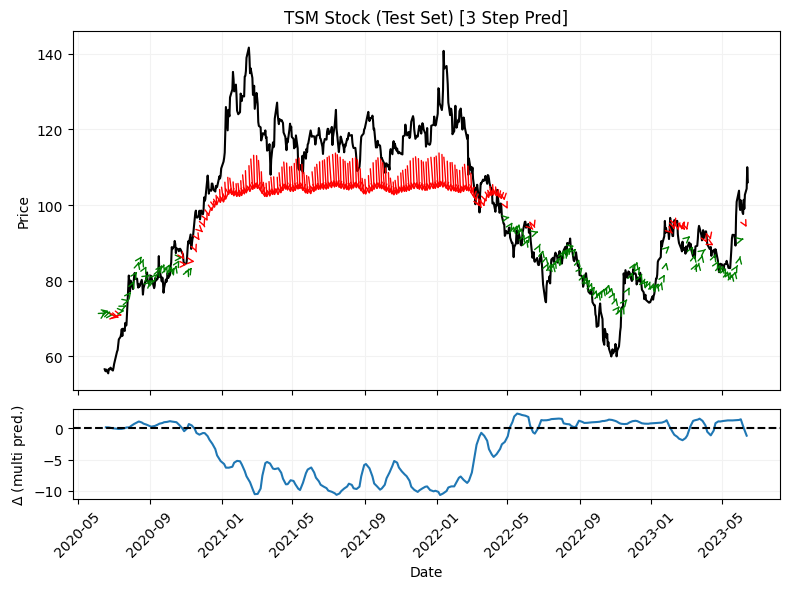

In [105]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4,1]})
step = 3
ax[0].set_title(name +' Stock (Test Set) ['+str(step)+' Step Pred]')
ax[0].set_ylabel('Price')
ax[0].grid(color="0.95")
ax[0].plot(forecast_date_array,truth_opens,label='Open',color='black')
counter = 0
sub_x,sub_y = [],[]
sub_ty = []
for i in range(len(unscaled_forecast)):
    xs = forecast_date_array[counter:counter+step]
    xs2 = forecast_date_array[counter+step-1]
    ys = unscaled_forecast[i]
    ys2 = ys[-1]-ys[0]
    ts = truth_opens[counter:counter+step]
    ts2 = ts[-1]-ts[0]
    counter += step
    if ys[-1]>ys[0]:
        ax[0].annotate('', xy=(xs[-1], ys[-1]), xytext=(xs[0], ys[0]),arrowprops=dict(arrowstyle='->', color='green'))
    else:
        ax[0].annotate('', xy=(xs[-1], ys[-1]), xytext=(xs[0], ys[0]),arrowprops=dict(arrowstyle='->', color='red'))
    #plot the arrows
    sub_x.append(xs2)
    sub_y.append(ys2)
    sub_ty.append(ts2)

# ax[0].set(xlim=(forecast_date_array[200],forecast_date_array[600]))
ax[1].plot(sub_x,sub_y)
# ax[1].plot(sub_x,sub_ty)
ax[1].axhline(0,ls='--',color='black')
ax[1].grid(color="0.95")
ax[1].set(xlabel='Date',ylabel='$\Delta$ (multi pred.)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    